## **1. Data Loading**

In [ ]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
!pip install nltk keras gensim scikit-learn

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2995 entries, 0 to 2994
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  2995 non-null   object
 1   category   2995 non-null   object
dtypes: object(2)
memory usage: 46.9+ KB
None

Sample data:
                                           utterance category
0  how to edit the information on my account? I'm...  ACCOUNT
1  I do not know what I need to do to switch user...  ACCOUNT
2  where can I switch user? Could you please prov...  ACCOUNT
3  what do I need to do to change the user detail...  ACCOUNT
4  I don't know what to do to switch to another a...  ACCOUNT


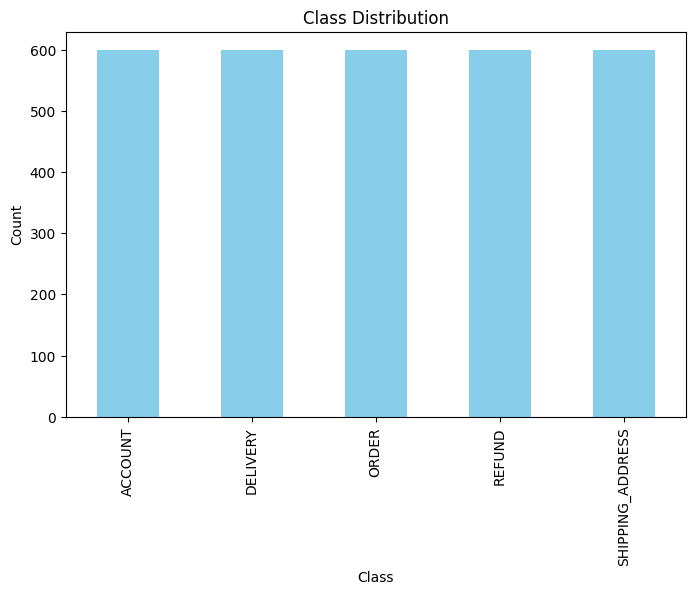

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/NLP/NLP_Mini_project/Dataset/balanced_dataset.csv')  # Replace with actual dataset path

# Exploratory Data Analysis (EDA)
print("Dataset overview:")
print(data.info())  # Checking for missing values, data types
print("\nSample data:")
print(data.head())  # Display the first few rows

# Plot class distribution
plt.figure(figsize=(8, 5))
data['category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Splitting data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

## **2. Text Processing**


*   Clean the text by removing stop words, punctuation, and special characters.
*   Tokenization: Convert sentences into lists of words/tokens.
*   Optionally, apply stemming or lemmatization to normalize words.



In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define constants
MAX_NUM_WORDS = 10000  # Max vocabulary size
MAX_SEQUENCE_LENGTH = 200  # Max length for padded sequences

# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

# Apply the preprocessing to the dataset
train_data['processed_text'] = train_data['utterance'].apply(preprocess_text)
val_data['processed_text'] = val_data['utterance'].apply(preprocess_text)
test_data['processed_text'] = test_data['utterance'].apply(preprocess_text)

# Initialize and fit tokenizer on the processed text
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['processed_text'])

# Convert processed text to sequences of word indices
train_data['text_sequences'] = tokenizer.texts_to_sequences(train_data['processed_text'])
val_data['text_sequences'] = tokenizer.texts_to_sequences(val_data['processed_text'])
test_data['text_sequences'] = tokenizer.texts_to_sequences(test_data['processed_text'])

# Pad sequences to ensure uniform input size
train_data['padded_sequences'] = pad_sequences(train_data['text_sequences'], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post').tolist()
val_data['padded_sequences'] = pad_sequences(val_data['text_sequences'], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post').tolist()
test_data['padded_sequences'] = pad_sequences(test_data['text_sequences'], maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post').tolist()

# Check the processed text and sequences
print(train_data[['utterance', 'processed_text', 'text_sequences', 'padded_sequences']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                              utterance  \
2107  is it possible to check how long refunds take?...   
1056  help me checking what delivery options I can c...   
1450  assistance to track an order I placed the orde...   
2813  I need information about the options for deliv...   
50    i cannot remember my account pwd i need help t...   

                                         processed_text  \
2107  possible check long refunds take ordered produ...   
1056  help checking delivery options choose delivery...   
1450  assistance track order placed order last week ...   
2813  need information options delivery delivery dat...   
50    remember account pwd need help restore trouble...   

                                         text_sequences  \
2107      [72, 6, 67, 58, 94, 30, 29, 31, 3, 4, 12, 32]   
1056  [5, 55, 7, 40, 95, 7, 24, 25, 3, 4, 8, 5, 20, 26]   
1450             [9, 61, 11, 35, 11, 21, 36, 4, 37, 34]   
2813     [33, 10, 40, 7, 7, 24, 25, 3, 4, 8, 5, 20, 26

## **3. Text Embedding**
*   Implement different types of embeddings for text conversion into numerical form:
   *  Bag of Words (BoW): Count-based method for representing text.
   *   TF-IDF: Weigh terms based on their frequency and importance.
   *   FastText: Pre-trained word embeddings that capture word meanings.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim

# Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_bow = bow_vectorizer.transform(val_data['processed_text']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['processed_text']).toarray()

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text']).toarray()

# FastText (Word Embeddings)
fasttext_model = gensim.models.FastText(train_data['processed_text'].apply(str.split), vector_size=100, window=5, min_count=5)
X_train_fasttext = [fasttext_model.wv[text.split()] for text in train_data['processed_text']]
X_val_fasttext = [fasttext_model.wv[text.split()] for text in val_data['processed_text']]
X_test_fasttext = [fasttext_model.wv[text.split()] for text in test_data['processed_text']]

print("Embedding completed for BoW, TF-IDF, and FastText.")

Embedding completed for BoW, TF-IDF, and FastText.


## **4. Model Training with Different Architectures**
*   Train deep learning models using the different embeddings:
 *     CNN (Convolutional Neural Network)
 *     LSTM (Long Short-Term Memory)
 *     BiLSTM (Bidirectional LSTM)
 *     CNN-BiLSTM: A hybrid model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam

def cnn_model(input_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=200))  # Reduced input length
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))  # Multi-class output
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def lstm_model(input_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=200))  # Reduced input length
    model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.3)))
    model.add(LSTM(64, dropout=0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))  # Multi-class output
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def cnn_bilstm_model(input_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=200))  # Reduced input length
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.3)))
    model.add(LSTM(64, dropout=0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))  # Multi-class output
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Extract padded sequences from train and validation data
X_train_seq = np.array(train_data['padded_sequences'].tolist())
X_val_seq = np.array(val_data['padded_sequences'].tolist())

# Encode categorical labels as integers
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_data['category'])
val_labels_encoded = label_encoder.transform(val_data['category'])

# Convert integer labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_train = to_categorical(train_labels_encoded, num_classes=num_classes)
y_val = to_categorical(val_labels_encoded, num_classes=num_classes)

# Define Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the CNN model
cnn = cnn_model(MAX_NUM_WORDS, num_classes)
cnn.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), epochs=5, batch_size=32, callbacks=[early_stopping])

# Train the LSTM model
lstm = lstm_model(MAX_NUM_WORDS, num_classes)
lstm.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

# Train the CNN-BiLSTM model
cnn_bilstm = cnn_bilstm_model(MAX_NUM_WORDS, num_classes)
cnn_bilstm.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.3214 - loss: 1.5892 - val_accuracy: 0.8292 - val_loss: 1.4843
Epoch 2/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8083 - loss: 1.3746 - val_accuracy: 0.8542 - val_loss: 0.8806
Epoch 3/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8541 - loss: 0.7013 - val_accuracy: 0.8667 - val_loss: 0.3655
Epoch 4/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8888 - loss: 0.3406 - val_accuracy: 0.8917 - val_loss: 0.2559
Epoch 5/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9004 - loss: 0.2689 - val_accuracy: 0.9542 - val_loss: 0.1871
Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.1840 - loss: 1.6107 - val_accuracy: 0.2292 - val_loss: 1.6076
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.1973 - loss: 1.6094 - val_accuracy: 0.2250 - val_loss: 1.6088
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.1860 - loss: 1.6107 - val_accuracy: 0.1792 - val_loss: 1.6104
Epo

## **5. Comparative Analysis of Models**
*  Create a comparison table showing the performance of each model based on metrics like accuracy, precision, recall, F1-score, and inference time on different embeddings (BoW, TF-IDF, FastText).

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Assuming you want to evaluate on the padded sequences:
X_test_seq = np.array(test_data['padded_sequences'].tolist())

# Evaluate CNN model
y_pred_cnn = cnn.predict(X_test_seq)
y_pred_cnn_labels = label_encoder.inverse_transform(y_pred_cnn.argmax(axis=1))
cnn_acc = accuracy_score(test_data['category'], y_pred_cnn_labels)
print("CNN Accuracy:", cnn_acc)
print("CNN Classification Report:\n", classification_report(test_data['category'], y_pred_cnn_labels))

# Evaluate LSTM model
y_pred_lstm = lstm.predict(X_test_seq)  # Use X_test_seq instead of X_test_bow
y_pred_lstm_labels = label_encoder.inverse_transform(y_pred_lstm.argmax(axis=1))  # Decode predictions
lstm_acc = accuracy_score(test_data['category'], y_pred_lstm_labels)  # Use decoded labels
print("LSTM Accuracy:", lstm_acc)
print("LSTM Classification Report:\n", classification_report(test_data['category'], y_pred_lstm_labels))  # Use decoded labels


# Evaluate CNN-BiLSTM model
y_pred_cnn_bilstm = cnn_bilstm.predict(X_test_seq)  # Use X_test_seq instead of X_test_bow
y_pred_cnn_bilstm_labels = label_encoder.inverse_transform(y_pred_cnn_bilstm.argmax(axis=1))  # Decode predictions
cnn_bilstm_acc = accuracy_score(test_data['category'], y_pred_cnn_bilstm_labels)  # Use decoded labels
print("CNN-BiLSTM Accuracy:", cnn_bilstm_acc)
print("CNN-BiLSTM Classification Report:\n", classification_report(test_data['category'], y_pred_cnn_bilstm_labels))  # Use decoded labels

# Summarize the results in a table
results = pd.DataFrame({
    'Model': ['CNN', 'LSTM', 'CNN-BiLSTM'],
    'Accuracy': [cnn_acc, lstm_acc, cnn_bilstm_acc]
})

print("\nSummary of Model Performance:")
print(results)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
CNN Accuracy: 0.9582637729549248
CNN Classification Report:
                   precision    recall  f1-score   support

         ACCOUNT       0.84      0.99      0.91       124
        DELIVERY       1.00      0.96      0.98       114
           ORDER       0.98      0.90      0.94       118
          REFUND       1.00      0.94      0.97       118
SHIPPING_ADDRESS       1.00      1.00      1.00       125

        accuracy                           0.96       599
       macro avg       0.96      0.96      0.96       599
    weighted avg       0.96      0.96      0.96       599

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
LSTM Accuracy: 0.19031719532554256
LSTM Classification Report:
                   precision    recall  f1-score   support

         ACCOUNT       0.19      0.27      0.22       124
        DELIVERY       0.00      0.00      0.00       114
           ORDER       0.14      0.08      0.11       118
          REFUND       0.18      0.22

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
CNN-BiLSTM Accuracy: 0.9716193656093489
CNN-BiLSTM Classification Report:
                   precision    recall  f1-score   support

         ACCOUNT       0.96      1.00      0.98       124
        DELIVERY       1.00      0.97      0.99       114
           ORDER       0.91      0.97      0.94       118
          REFUND       1.00      0.91      0.95       118
SHIPPING_ADDRESS       1.00      1.00      1.00       125

        accuracy                           0.97       599
       macro avg       0.97      0.97      0.97       599
    weighted avg       0.97      0.97      0.97       599


Summary of Model Performance:
        Model  Accuracy
0         CNN  0.958264
1        LSTM  0.190317
2  CNN-BiLSTM  0.971619


## **Validation functions for each models**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def validate_model(model, X_val, y_val, model_name):
    # Predict class probabilities
    y_pred_prob = model.predict(X_val)

    # Convert probabilities to class labels
    y_pred = y_pred_prob.argmax(axis=1)
    y_true = y_val.argmax(axis=1)

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Print evaluation results
    print(f"\nValidation Results for {model_name} ")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Validate all models
validate_model(cnn, X_val_seq, y_val, "CNN Model")
validate_model(lstm, X_val_seq, y_val, "LSTM Model")
validate_model(cnn_bilstm, X_val_seq, y_val, "CNN-BiLSTM Model")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step

Validation Results for CNN Model 
Accuracy: 0.9542

Classification Report:
                  precision    recall  f1-score   support

         ACCOUNT       0.83      1.00      0.91        50
        DELIVERY       1.00      0.93      0.96        40
           ORDER       0.98      0.91      0.94        45
          REFUND       1.00      0.92      0.96        53
SHIPPING_ADDRESS       1.00      1.00      1.00        52

        accuracy                           0.95       240
       macro avg       0.96      0.95      0.95       240
    weighted avg       0.96      0.95      0.96       240

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Validation Results for LSTM Model 
Accuracy: 0.1958

Classification Report:
                  precision    recall  f1-score   support

         ACCOUNT       0.31      0.30      0.30        50
        DELIVERY       0.00      0.00      0.00        40
           ORDER       0.17      0.07      0.10        45
          REF

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **6. Saving the Best Model**
*  Identify and save the model with the best performance based on validation/testing results (save it in a format such as .h5 or .pt).

In [ ]:
# Saving the best model (assuming CNN performed best)
cnn.save('best_text_classification_model.h5')
print("Best model saved as 'best_text_classification_model.h5'")

Best model saved as 'best_text_classification_model.h5'


## **7. Prediction on Real-World Input**
*  Test the saved model on real-world input data.
Preprocess the input text as done earlier and use the model to predict classes.
Output predictions with confidence scores or probabilities.

In [ ]:
# Load the saved model
from keras.models import load_model
model = load_model('best_text_classification_model.h5')

# Real-world input
new_text = "can you show me what delivery options I have? The delivery date has passed, but I still haven't received my package. Can you help me find out what happened?"
processed_text = preprocess_text(new_text)

# Use tokenizer to transform the text to sequences
# This ensures consistency with how the model was trained
new_text_sequence = tokenizer.texts_to_sequences([processed_text])
new_text_padded = pad_sequences(new_text_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')


# Predicting the class of new text
predicted_class = model.predict(new_text_padded).round()
#The predicted class is in one-hot encoding format
#Convert it back to the original label
predicted_label = label_encoder.inverse_transform(np.argmax(predicted_class, axis=1))

print(f"Predicted Class: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
Predicted Class: DELIVERY
